<a href="https://colab.research.google.com/github/azharharisandi14/Geoscience_Experiments/blob/master/Wedge_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wedge Modeling

Similarly, in this notebook i will try to recreate wedge model inspired by Matt Hall's and Alesandro Amato del Monte notebook on creating a wedge model. But i'm going to create my own class of wedge from scratch. The code might not be the prettiest and the most efficient code to do this, so if anyone has an idea for improvement, I would gladly receive your response.

* aadm's : https://github.com/aadm/geophysical_notes/blob/master/wedge_modeling.ipynb
* Agile Scientific : https://agilescientific.com/blog/2016/9/15/x-lines-of-python-synthetic-wedge-model

Wedge model is a standard model for interpreter to check wheter a bright amplitude in the seismic is associated with tuning effect or fluid/hydrocarbon effect. The tuning name itself comes from the phenomenon associated with thin beds where two seismic pulses exhibit constructive interference as one bed thins out.


# Function definition and import module

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import hilbert


def ricker(f, length, dt, phase):
  '''taken from Matt Hall's well-tie calculus with a bit of 
  modification to adjust the initial phase of the wavelet. The trade off is we have to
  import hilbert from scipy.signal'''
  t = np.linspace(-length/2, (length-dt)/2, int(length/dt))
  s = (1. - 2.*((np.pi)**2)*(f**2)*((t)**2))*np.exp(-((np.pi)**2)*(f**2)*((t)**2))
  
  phase = np.deg2rad(phase)
  s = hilbert(s)
  s = np.cos(phase)*np.real(s)-np.sin(phase)*np.imag(s)
  return t, s


class wedge:
    """
        return 3 layers wedge model with parameters:
        1. p = list of layer 1, 2, and 3 physical properties
        2. t1,t2 = wedge thickness, t1 thinnest, t2 thickest (depth or time)
        3. dx = trace spacing (meter)
        4. dz = vertical scale spacing (whether it is depth or time)
        5. offset = point where layer 2 vanishes / pinched out
        6. nt = number of traces
        7. cmap = colormap of the plot
        8. label = name of the parameter
    """
    def __init__(self,p,t1=0,t2=40,dx=15,dz=0.15,offset=5,nt=50):

      self.p = p
      self.offset = offset
      self.x = np.arange(0,(nt*dx)+dx,dx)
      self.z = np.arange(0,3*t2,dz)
      self.dt = (t2-t1)/(len(self.x)-1-offset) # thickness increment per trace
      self.nt = nt
      self.t1 = t1
      self.t2 = t2

    def info(self):
      print(f"matrix size {(len(self.z),len(self.x))}, number of traces : {offset}" )
    

    def make_wedge(self):
      
      self.t = np.zeros(self.x.shape)
      self.arr = np.zeros((len(self.z),len(self.x)))
      for i in range(0,len(self.arr[1,:])):
          if i < self.offset:
              self.t[i] = 0
              for j,zs in enumerate(self.z):
                  if zs < self.t2:
                      self.arr[j,i] = self.p[0]
                  else:
                      self.arr[j,i] = self.p[2]
          else:  
              self.t[i] = self.t1+(i-self.offset)*self.dt
              for j,zs in enumerate(self.z):
                  if zs < self.t2:
                      self.arr[j,i] = self.p[0]
                  elif (zs>=t2)&(zs<(t2+self.t[i])):
                      self.arr[j,i] = self.p[1]
                  else:
                      self.arr[j,i] = self.p[2]
    

    def plot_wedge(self,cmap='viridis',label='vp'):

      # plt.figure()
      plt.pcolormesh(self.arr,cmap=cmap)
      plt.gca().invert_yaxis()

      s = int(self.nt/10)
      plt.xticks(np.arange(self.offset,len(self.x),s),labels=[np.round(self.t[i],2) for i in np.arange(offset,len(self.x),s)])
      plt.xlim([0,self.nt])
      plt.xlabel("wedge thickness (m)", labelpad = 10)

      s = 100
      plt.yticks(np.arange(0,len(self.z),s),labels=[np.round(self.z[i]) for i in np.arange(0,len(self.z),s)])
      plt.ylabel("Depth (m)", labelpad = 10)

      plt.title(label+' wedge model' )

    def tdc(self,mat,v,si=0.5):
      """Input : 
      1. mat = array to be converted 
      2. v = list/array velocity of layer 1,2 and 3
      3. si = sampling interval (in milliseconds)
      """
      self.twt = np.zeros(len(mat[1,:]))
      for i in range(0,len(mat[1,:])):
        self.twt[i] = (self.t2/v[0])*2000 #1st layer Interval time
        self.twt[i] += (self.t[i]/v[1])*2000 #2nd Layer Interval time
        self.twt[i] += ((3*self.t2 - self.t2 - self.t[i])/v[2])*2000 #3rd layer Interval time

      zt = (np.arange(0,np.amax(self.twt),si)) #z axis for time domain

      self.twt_b1 = (self.t2/v[0])*2000 #twt 1st boundary 
      self.twt_b2 = ((self.t/v[1])*2000) + self.twt_b1 #twt 2nd boundary

      
      self.arr_t = np.zeros((len(zt),len(self.x)))
      for i in range(0,len(self.arr_t[1,:])):
              if i < self.offset:
                  for j,zs in enumerate(zt):
                      if zs < self.twt_b1:
                          self.arr_t[j,i] = v[0]
                      else:
                          self.arr_t[j,i] = v[2]
              else:  
                  for j,zs in enumerate(zt):
                      if zs < self.twt_b1:
                          self.arr_t[j,i] = v[0]
                      elif (zs>=self.twt_b1)&(zs<self.twt_b2[i]):
                          self.arr_t[j,i] = v[1]
                      else:
                          self.arr_t[j,i] = v[2]

        


pretty good 

# Array initialization 

matrix size (800, 81), number of traces : 0


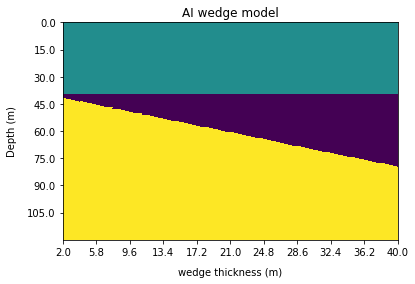

In [373]:
v = [2200,2000,2400]
vs = [1400,1500,1600]
rho = [2.5,2.4,2.6]
AI = np.array(v)*np.array(rho)

t1=2 ; t2=40
dx=15 ; dz=0.15
offset=0; nt=80

vp_w = wedge(v,t1,t2,dx,dz,offset,nt)
vp_w.make_wedge() #This method returns an attribute of 2d array (self.arr) with proprty value from input list

vs_w = wedge(vs,t1,t2,dx,dz,offset,nt)
vs_w.make_wedge()

rho_w = wedge(rho,t1,t2,dx,dz,offset,nt)
rho_w.make_wedge()

ai_w = wedge(AI,t1,t2,dx,dz,offset,nt)
ai_w.info()
ai_w.make_wedge()
ai_w.plot_wedge(label='AI')


# Time to Depth Conversion

(219, 81)


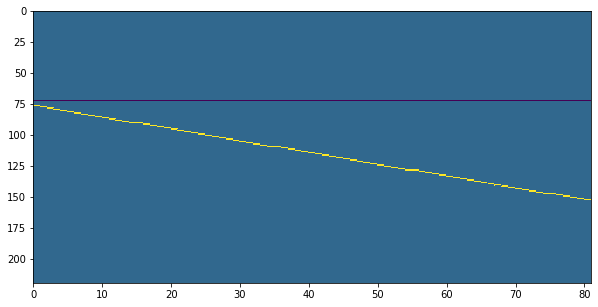

In [374]:
si = 0.5 #sampling interval
ai_w.tdc(ai_w.arr,v,si=si) #tdc method returns an attribute of 2d array self.arr_t, just like self.arr but in _t (time-domain)
rc_t = np.diff(ai_w.arr_t,axis=0)

plt.figure(figsize=(10,5))
plt.pcolormesh(rc_t)
plt.gca().invert_yaxis()

print(rc_t.shape)

# Convolution

operator length : 180, rc series length : 219


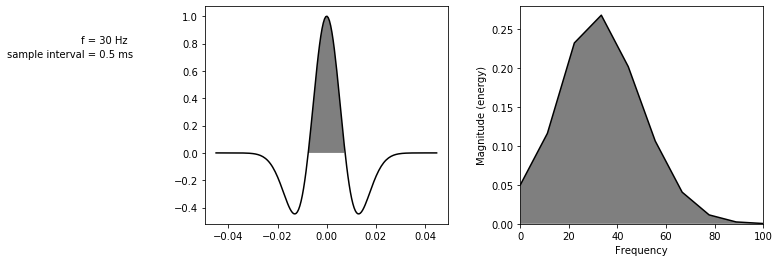

In [375]:
freq = 30; dt = si/1000 #in seconds; 
length = 0.09 #operator length = 2*length, but keep the operator length < than reflectivity series length, otherwise the convolution results will smear out adding extra data in start and the end of the signal

#Create a wavelet
tw,y = ricker(f=freq, length=length, dt=dt, phase=0)

#plot wavelet
f,ax=plt.subplots(1,2,figsize=(10,4))
f.subplots_adjust(wspace = 0.3)

ax[0].plot(tw,y,'k')
ax[0].fill_between(tw,0,y,where=y>0,facecolor='black',alpha=0.5)
ax[0].text(-0.1,0.8,f'f = {freq} Hz')
ax[0].text(-0.13,0.7,f'sample interval = {dt*1000} ms ')

mag,freq,line=ax[1].magnitude_spectrum(y,Fs=1/dt,c='k')
ax[1].set_xlim(0,100)
ax[1].fill_between(freq,0,mag,facecolor='k',alpha=0.5)
ax[1].set_ylim(0,np.max(mag)+np.mean(mag))

print(f'operator length : {len(y)}, rc series length : {len(rc_t)}')

In [0]:
synth = np.apply_along_axis(lambda t: np.convolve(t, y, mode='same'),axis=0,arr=rc_t)


# f,ax = plt.subplots(figsize=(10,6))
# ax.imshow(synth,cmap="RdBu_r",origin="upper",interpolation='bicubic',resample=True)
# ax.set_aspect(0.35)


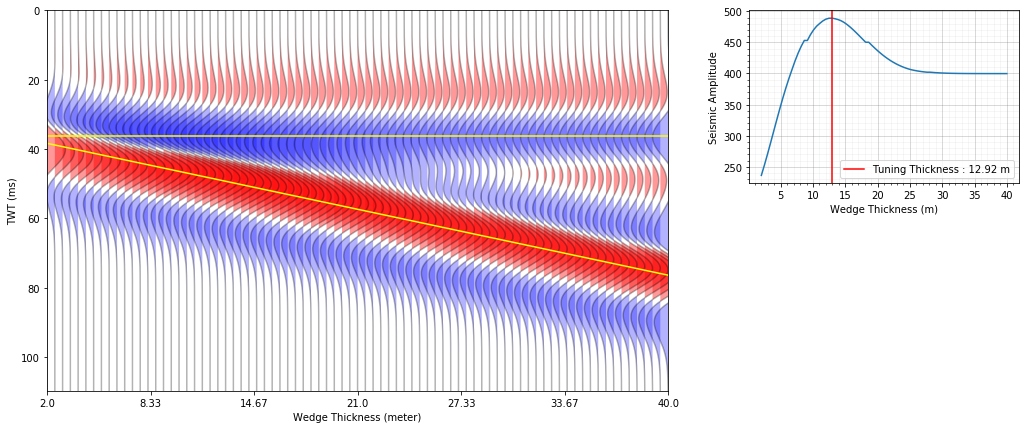

In [378]:
#map z axis to new array size

zt = (np.linspace(0,np.amax(ai_w.twt),synth.shape[0]))
gain = 1 #Trace gain
max_amp = np.zeros(synth.shape[1])

f,ax = plt.subplots(1,2,figsize=(15,7))
f.subplots_adjust(wspace = 0.3, left=0.05, right=0.95)

ax0 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
ax1 = plt.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)

for i in np.arange(synth.shape[1]):
    ax0.plot(synth[:,i]*gain+i*100,zt,'k',alpha=0.3)
    ax0.fill_betweenx(zt,synth[:,i]*gain+i*100,i*100,where=synth[:,i]*gain+i*100 > i*100,interpolate = True,facecolor='red',alpha=0.4)
    ax0.fill_betweenx(zt,synth[:,i]*gain+i*100,i*100,where=synth[:,i]*gain+i*100 < i*100,interpolate = True,facecolor='blue',alpha=0.3)
    max_amp[i] = np.amax(abs(synth[:,i]))

ax0.set_xlim([0,100*nt])
ax0.set_ylim([0,np.max(zt)])
ax0.plot(np.linspace(0,nt*100,len(ai_w.twt_b2)),ai_w.twt_b2,color='yellow')
ax0.axhline(ai_w.twt_b1,xmin=0,xmax=nt*100,color='yellow')
n_ticks = 7
ax0.set_xticks(np.linspace(0,100*nt,n_ticks))
ax0.set_xticklabels(np.round(np.linspace(ai_w.t1,ai_w.t2,n_ticks),2))
ax0.set_xlabel("Wedge Thickness (meter)")
ax0.set_ylabel("TWT (ms)")
ax0.invert_yaxis()

# plt.imshow(synth,extent=[0,nt*100,max(zt),min(zt)],origin="upper",aspect='auto',cmap='RdBu_r',alpha=0.8)
tuning = ai_w.t[np.argmax(max_amp)] #This is still a mystery how to exactly find the peak or the trough
ax1.plot(ai_w.t,max_amp)
ax1.axvline(tuning,ymin=0,ymax=np.max(max_amp),c='red',label=f"Tuning Thickness : {np.round(tuning,2)} m")
ax1.set_xlabel("Wedge Thickness (m)")
ax1.set_ylabel("Seismic Amplitude")
ax1.minorticks_on()
ax1.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.3)
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax1.legend()

So that's all, i left the last plotting script out of the class because i think some people would rather have their wedge plotted in different way, anyway i showed how to plot the wedge and you can modify it to your preference and put it into your own class/method for faster and simpler regular use

You should read this article if you're interested in this topic
 * https://wiki.seg.org/wiki/Thin_beds,_tuning,_and_AVO
 * https://wiki.seg.org/wiki/Tuning
